In [1]:
# rm(list = ls())
setwd("/mnt/c/git_repos/iORD_hepatitis/")
require(tidyverse)
require(data.table)
require(lubridate)
require(foreach)
require(doParallel)
require(randomcoloR)
require(ggpubr)


Loading required package: tidyverse
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: data.table

Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

The following object is masked from ‘package:purrr’:

    transpose

Loading required package: lubridate

Attaching package: ‘lubridate’

The following objects are masked from ‘

### Load data

In [2]:
age_df <- fread("data/IORD_ASHep-UE_34_20230120_Attendances.csv") %>%
    mutate(AttendanceStartDate = as.Date(AttendanceStartDate),
           AttendanceEndDate = as.Date(AttendanceEndDate),
           LinkedBirthmonth = as.Date(LinkedBirthmonth)) %>%
    mutate(age_upon_presentation = time_length(AttendanceStartDate -
                                               LinkedBirthmonth, "year")) %>%
    mutate(age_upon_presentation = floor(age_upon_presentation)) %>% 
    mutate(age_group = case_when(age_upon_presentation < 7 ~ "<7",
                                 age_upon_presentation >= 6 & age_upon_presentation <= 15 ~ "7-15",
                                 age_upon_presentation >= 16 ~ ">15")) %>%
    filter(AttendanceStartDate < as.Date("2023-01-01")) %>%
    arrange(AttendanceStartDate)

micro_df <- fread("data/IORD_ASHep-UE_34_20230120_Microbiology.csv") %>%
    mutate(AttendanceStartDate = as.Date(AttendanceStartDate)) %>%
    left_join(age_df) %>%
    mutate(AttendanceMonth = cut(AttendanceStartDate, breaks = "month"),
           AttendanceTwoMonth = cut(AttendanceStartDate, breaks = "2 months")) %>%
    mutate(AttendanceStartDate = as.Date(AttendanceStartDate),
           AttendanceMonth = as.Date(AttendanceMonth),
           AttendanceTwoMonth = as.Date(AttendanceTwoMonth)) %>%
    filter(AttendanceMonth < as.Date("2023-01-01")) %>%
    rename(MicroTestName = TestName) %>%
    # Parse records
    mutate(BugName = ifelse(BatTestCode == "QADN" & ResultFull == "DETECTED", "Adenovirus", BugName)) %>%
    mutate(BugName = ifelse(grepl("Adenovirus", BugName, ignore.case = T), "Adenovirus", BugName)) %>%
    mutate(BugName = ifelse(BatTestCode %in% c('CV2G', 'CV2G2', 'CV2P', 'CV2Q', 'CV2V', 'RCV2Q', 'RCV2V') &
                            !grepl("not detected| |NONE|indeterminate", ResultFull, ignore.case = T),
                            "SARS-CoV-2", BugName)) %>%
    mutate(BugName = ifelse(grepl("SARS Coronavirus-2", BugName, ignore.case = T), "SARS-CoV-2", BugName)) %>%
    mutate(BugName = ifelse(grepl("Staphy", BugName, ignore.case = T), "Staphylococcus", BugName)) %>%
    mutate(BugName = ifelse(grepl("Strep", BugName, ignore.case = T), "Streptococcus", BugName)) %>%
    mutate(BugName = ifelse(grepl("Candida", BugName, ignore.case = T), "Candida", BugName)) %>%
    mutate(BugName = ifelse(grepl("influenza a|influenza b|flu a|flu b", BugName, ignore.case = T), "Influenza", BugName)) %>%
    mutate(BugName = ifelse(grepl("Escherichia|E. coli", BugName, ignore.case = T), "Escherichia", BugName)) %>%
    mutate(BugName = ifelse(grepl("Enterococcus", BugName, ignore.case = T), "Enterococcus", BugName)) %>%
    mutate(BugName = ifelse(grepl("Klebsiella", BugName, ignore.case = T), "Klebsiella", BugName)) %>%
    mutate(BugName = ifelse(grepl("Acinetobacter", BugName, ignore.case = T), "Acinetobacter", BugName)) %>%
    mutate(BugName = ifelse(grepl("Bacillus", BugName, ignore.case = T), "Bacillus", BugName)) %>%
    mutate(BugName = ifelse(grepl("HAEMOPHILUS", BugName, ignore.case = T), "Haemophilus", BugName)) %>%
    mutate(BugName = ifelse(grepl("Parvimonas", BugName, ignore.case = T), "Parvimonas", BugName)) %>%
    mutate(BugName = ifelse(grepl("Burkholderia", BugName, ignore.case = T), "Burkholderia", BugName)) %>%
    mutate(BugName = ifelse(grepl("Micrococcus", BugName, ignore.case = T), "Micrococcus", BugName)) %>%
    mutate(BugName = ifelse(grepl("Proteus", BugName, ignore.case = T), "Proteus", BugName)) %>%
    mutate(BugName = ifelse(grepl("Lactococcus", BugName, ignore.case = T), "Lactococcus", BugName)) %>%
    mutate(BugName = ifelse(grepl("Rothia", BugName, ignore.case = T), "Rothia", BugName)) %>%
    mutate(BugName = ifelse(grepl("Salmonella", BugName, ignore.case = T), "Salmonella", BugName)) %>%
    mutate(BugName = ifelse(grepl("Actinomyces", BugName, ignore.case = T), "Actinomyces", BugName)) %>%
    mutate(BugName = ifelse(grepl("ANAEROCOCCUS", BugName, ignore.case = T), "Anaerococcus ", BugName)) %>%
    mutate(BugName = ifelse(grepl("Pseudomonas", BugName, ignore.case = T), "Pseudomonas", BugName)) %>%
    mutate(BugName = ifelse(grepl("Corynebacterium", BugName, ignore.case = T), "Corynebacterium", BugName)) %>%
    mutate(BugName = ifelse(grepl("Yersinia", BugName, ignore.case = T), "Yersinia", BugName)) %>%
    mutate(BugName = ifelse(grepl("ASPERGILLUS", BugName, ignore.case = T), "Aspergillus", BugName)) %>%
    mutate(BugName = ifelse(grepl("TURICELLA", BugName, ignore.case = T), "Turicella", BugName)) %>%
    mutate(BugName = ifelse(grepl("serratia", BugName, ignore.case = T), "Serratia", BugName)) %>%
    mutate(BugName = ifelse(grepl("moraxella", BugName, ignore.case = T), "Moraxella", BugName)) %>%
    mutate(BugName = ifelse(grepl("bacteroides", BugName, ignore.case = T), "Bacteroides", BugName)) %>%
    mutate(BugName = ifelse(grepl("shigella", BugName, ignore.case = T), "Shigella", BugName)) %>%
    mutate(BugName = ifelse(grepl("enterobacter", BugName, ignore.case = T), "Enterobacter", BugName)) %>%
    mutate(BugName = ifelse(grepl("GORDONIA", BugName, ignore.case = T), "Gordonia", BugName)) %>%
    mutate(BugName = ifelse(grepl("rhinovirus|enterovirus", BugName, ignore.case = T), "Rhinovirus/Enterovirus", BugName)) %>%
    mutate(BugName = ifelse(grepl("aerococcus", BugName, ignore.case = T), "Aerococcus", BugName)) %>%
    mutate(BugName = ifelse(grepl("aeromonas", BugName, ignore.case = T), "Aeromonas", BugName)) %>%
    mutate(BugName = ifelse(grepl("Raoultella", BugName, ignore.case = T), "Raoultella", BugName)) %>%
    mutate(BugName = ifelse(grepl("Brevibacterium", BugName, ignore.case = T), "Brevibacterium", BugName)) %>%
    mutate(BugName = ifelse(grepl("Prevotella", BugName, ignore.case = T), "Prevotella", BugName)) %>%
    mutate(BugName = ifelse(grepl("Trichophyton", BugName, ignore.case = T), "Trichophyton", BugName)) %>%
    mutate(BugName = ifelse(grepl("Parainfluenzavirus|parainfluenza virus", BugName, ignore.case = T), "Parainfluenzavirus", BugName)) %>%
    mutate(BugName = ifelse(grepl("Clostridium", BugName, ignore.case = T), "Clostridium", BugName)) %>%
    mutate(BugName = ifelse(grepl("Neisseria", BugName, ignore.case = T), "Neisseria", BugName)) %>%
    mutate(BugName = ifelse(grepl("Fusobacterium", BugName, ignore.case = T), "Fusobacterium", BugName)) %>%
    mutate(BugName = ifelse(grepl("Atopobium", BugName, ignore.case = T), "Atopobium", BugName)) %>%
    mutate(BugName = ifelse(grepl("Aggregatibacter", BugName, ignore.case = T), "Aggregatibacter", BugName)) %>%
    mutate(BugName = ifelse(grepl("Sphingobacterium", BugName, ignore.case = T), "Sphingobacterium", BugName)) %>%
    mutate(BugName = ifelse(grepl("Bradyrhizobium", BugName, ignore.case = T), "Bradyrhizobium", BugName)) %>%
    mutate(BugName = ifelse(grepl("Ruminococcus", BugName, ignore.case = T), "Ruminococcus", BugName)) %>%
    mutate(BugName = ifelse(grepl("Alcaligenes", BugName, ignore.case = T), "Alcaligenes", BugName)) %>%
    mutate(BugName = ifelse(grepl("Paracoccus", BugName, ignore.case = T), "Paracoccus", BugName)) %>%
    mutate(BugName = ifelse(grepl("HAEMATOBACTER", BugName, ignore.case = T), "Haematobacter", BugName)) %>%
    mutate(BugName = ifelse(grepl("Microbacterium", BugName, ignore.case = T), "Microbacterium", BugName)) %>%
    mutate(BugName = ifelse(grepl("Mycobacterium", BugName, ignore.case = T), "Mycobacterium", BugName)) %>%
    mutate(BugName = ifelse(grepl("Citrobacter", BugName, ignore.case = T), "Citrobacter", BugName)) %>%
    mutate(BugName = ifelse(grepl("Propionibacterium", BugName, ignore.case = T), "Cutibacterium", BugName)) %>%
    mutate(BugName = ifelse(grepl("Respiratory Syncytial Virus", BugName, ignore.case = T), "RSV", BugName)) %>%
    mutate(BugName = ifelse(grepl("Herpes|varicella", BugName, ignore.case = T), "Herpesvirus", BugName)) %>%
    mutate(BugName = ifelse(grepl("ACHROMOBACTER", BugName, ignore.case = T), "Achromobacter", BugName)) %>%
    mutate(BugName = ifelse(grepl("Kocuria", BugName, ignore.case = T), "Kocuria", BugName)) %>%
    mutate(BugName = ifelse(grepl("Roseomonas", BugName, ignore.case = T), "Roseomonas", BugName)) %>%
    mutate(BugName = ifelse(grepl("Morganella", BugName, ignore.case = T), "Morganella", BugName)) %>%
    mutate(BugName = ifelse(grepl("Listeria", BugName, ignore.case = T), "Listeria", BugName)) %>%
    mutate(BugName = ifelse(grepl("Chlamydia", BugName, ignore.case = T), "Cutibacterium", BugName)) %>%
    mutate(BugName = ifelse(grepl("Stenotrophomonas", BugName, ignore.case = T), "Stenotrophomonas", BugName)) %>%
    mutate(BugName = ifelse(grepl("Sphingomonas", BugName, ignore.case = T), "Sphingomonas", BugName)) %>%
    mutate(BugName = ifelse(grepl("VEILLONELLA", BugName, ignore.case = T), "Veillonella", BugName)) %>%
    mutate(BugName = ifelse(grepl("Finegoldia", BugName, ignore.case = T), "Finegoldia", BugName)) %>%
    mutate(BugName = ifelse(grepl("Pasteurella", BugName, ignore.case = T), "Pasteurella", BugName)) %>%
    mutate(BugName = ifelse(grepl("Campylobacter", BugName, ignore.case = T), "Campylobacter", BugName)) %>%
    mutate(BugName = ifelse(grepl("Rhizobium", BugName, ignore.case = T), "Rhizobium", BugName)) %>%
    mutate(BugName = ifelse(grepl("PEPTONIPHILUS", BugName, ignore.case = T), "Peptoniphilus", BugName)) %>%
    mutate(BugName = ifelse(grepl("Brevundimonas", BugName, ignore.case = T), "Brevundimonas", BugName)) %>%
    mutate(BugName = ifelse(grepl("GEMELLA", BugName, ignore.case = T), "Gemella", BugName)) %>%
    mutate(BugName = ifelse(grepl("cocci|colonies|aerobic|anaerobic|anaerobes|gram positive|gram negative|Fungal", BugName, ignore.case = T), "ambiguous", BugName))

test_df <- fread("data/IORD_ASHep-UE_34_20230120_LIMS.csv") %>%
    mutate(CollectionDateTime = as.Date(CollectionDateTime),
           AttendanceStartDate = as.Date(AttendanceStartDate)) %>%
    filter(AttendanceStartDate < as.Date("2023-01-01"))

test_parsed <- test_df %>%
    distinct(ClusterID, AttendanceStartDate, TestName, .keep_all = T) %>%
    separate(RefRange, into = c("LLN", "ULN"), sep = "-") %>%
    mutate(ULN = as.numeric(ULN)) %>%
    select(-CollectionDateTime, -ReceiveDateTime) %>%
    mutate(Value = as.numeric(Value)) %>%
    mutate(Value = ifelse(is.na(Value), 0, Value)) %>%
    mutate(value_class = case_when(Value <= ULN ~ "Normal <= ULN",
                                 Value > ULN & Value <= 2 * ULN ~ "Mild (1-2x ULN)",
                                 Value > 2 * ULN & Value <= 5 * ULN  ~ "Moderate (2-5x ULN)",
                                 Value > 5 * ULN ~ "Severe (>5x ULN)")) %>%
    mutate(value_class = factor(value_class, c("Normal <= ULN", 
                                               "Mild (1-2x ULN)", 
                                               "Moderate (2-5x ULN)",
                                               "Severe (>5x ULN)"))) 

diag_df <- fread("data/IORD_ASHep-UE_34_20230120_DiagnosisCodes.csv") %>%
    left_join(fread("data/IORD_ASHep-UE_34_20230120_InpatientSpells.csv")) %>%
    mutate(AttendanceStartDate = as.Date(AttendanceStartDate)) %>%
    left_join(age_df) %>%
    mutate(age_upon_presentation = floor(age_upon_presentation)) %>% 
    mutate(age_group = case_when(age_upon_presentation < 7 ~ "<7",
                                 age_upon_presentation >= 6 & age_upon_presentation <= 15 ~ "7-15",
                                 age_upon_presentation >= 16 ~ ">15")) %>%
    mutate(AttendanceMonth = cut(AttendanceStartDate, breaks = "month"),
           AttendanceTwoMonth = cut(AttendanceStartDate, breaks = "2 months")) %>%
    mutate(AttendanceMonth = as.Date(AttendanceMonth),
           AttendanceTwoMonth = as.Date(AttendanceTwoMonth)) %>%
    arrange(AttendanceMonth) %>%
    filter(AttendanceStartDate < as.Date("2023-01-01"))

spell_df <- fread("data/IORD_ASHep-UE_34_20230120_InpatientSpells.csv") %>%
    mutate(AttendanceStartDate = as.Date(AttendanceStartDate)) %>%
    filter(AttendanceStartDate < as.Date("2023-01-01"))

vital_df <- fread("data/IORD_ASHep-UE_34_20230120_VitalSigns.csv") %>%
    distinct(ClusterID, AttendanceStartDate, EventName, .keep_all = T) %>%
    mutate(AttendanceStartDate = as.Date(AttendanceStartDate)) %>%
    filter(AttendanceStartDate < as.Date("2023-01-01"))

# all_months <- cut(seq(as.Date("2016-03-01"), as.Date("2022-12-01"), by = "1 month"), breaks = "1 month")
# all_months_df <- tibble(AttendanceMonth = rep(as.Date(all_months),3),
#                         age_group = c(rep("<7", length(all_months)),
#                                       rep("7-15", length(all_months)),
#                                       rep(">15", length(all_months))))

Joining, by = c("ClusterID", "AttendanceStartDate")
Warning message:
“NAs introduced by coercion”Warning message:
“NAs introduced by coercion”Joining, by = c("ClusterID", "SpellID")
Joining, by = c("ClusterID", "AttendanceStartDate")


In [3]:
micro_df2 <- fread("data/IORD_ASHep-UE_34_20230120_Microbiology.csv")

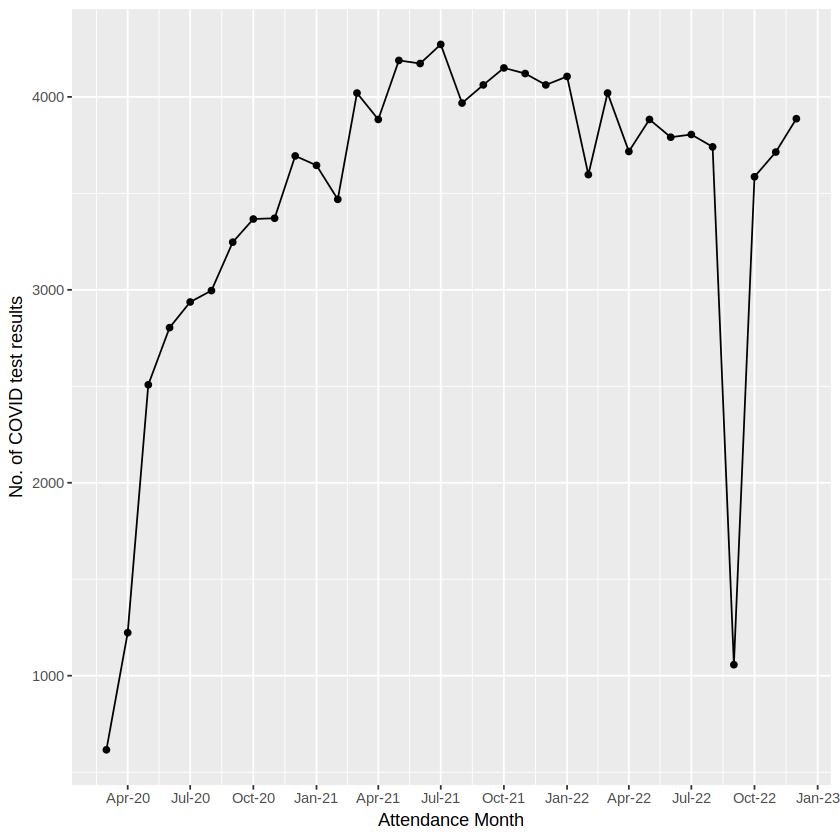

In [4]:
micro_df %>%
    filter(BatTestCode %in% c('CV2G', 'CV2G2', 'CV2P', 'CV2Q', 'CV2V', 'RCV2Q', 'RCV2V')) %>%
    distinct(ClusterID, AttendanceStartDate, .keep_all = T) %>%
    group_by(AttendanceMonth) %>%
    summarise(n = n()) %>%
    ggplot(aes(x = AttendanceMonth, y = n)) +
    geom_point() +
    geom_line() +
    scale_x_date(date_labels="%b-%y", date_breaks  = "3 month") +
    labs(x = "Attendance Month", y =  "No. of COVID test results")



In [5]:
micro_df %>%
#     filter(MicroTestName == "ADENOVIRUS DNA") %>%
#     filter(AttendanceStartDate > as.Date("2020-04-01")) %>%
    filter(BugName == "Adenovirus") %>%
    distinct(SpecimenFull, ResultFull)

SpecimenFull,ResultFull
NOSE & THROAT SWAB,"Adenovirus DETECTED(by BIOFIRE) RHINOVIRUS/ENTEROVIRUS DETECTED (by BIOFIRE) This specimen has been tested using PCR which detects Adenovirus, Coronavirus 229E, Coronavirus HKU1, Coronavirus NL63, Coronavirus OC43, Human Metapneumovirus, Human Rhinovirus / Enterovirus,"
NOSE & THROAT SWAB,"Adenovirus DETECTEDHUMAN RHINOVIRUS/ENTEROVIRUS DETECTED (by BIOFIRE) This specimen has been tested using PCR which detects Adenovirus, Coronavirus 229E, Coronavirus HKU1, Coronavirus NL63, Coronavirus OC43, Human Metapneumovirus, Human Rhinovirus / Enterovirus, Influe"
NOSE & THROAT SWAB,"Adenovirus DETECTED(by BIOFIRE) This specimen has been tested using PCR which detects Adenovirus, Coronavirus 229E, Coronavirus HKU1, Coronavirus NL63, Coronavirus OC43, Human Metapneumovirus, Human Rhinovirus / Enterovirus, Influenza A, Influenza B, Middle East Respir"
THROAT SWABTHROAT SWAB,"Influenza B virus DETECTEDAdenovirus DETECTED This specimen has been tested for Influenza A, A (H1/N1), B, Rhinovirus, Coronaviruses, Parainfluenza's 1/2/3 and 4, Adenovirus, Metapneumovirus, Respiratory Syncytial virus, Enterovirus, Parechovirus, Bocavirus and Mycoplasma pne"
BRONCHO-ALVEOLAR LAVAGE,"No microorganisms detectedby PCR (by BIOFIRE) This specimen has been tested using PCR which detects Adenovirus, Coronavirus 229E, Coronavirus HKU1, Coronavirus NL63, Coronavirus OC43, Human Metapneumovirus, Human Rhinovirus / Enterovirus, Influenza A, Influenza B, Middle East"
NASOPHARYNGEAL ASPIRATE;Nostril R,"Adenovirus DETECTED(by BIOFIRE) RHINOVIRUS/ENTEROVIRUS DETECTED (by BIOFIRE) Influenza A virus DETECTED (by BIOFIRE) This specimen has been tested using PCR which detects Adenovirus, Coronavirus 229E, Coronavirus HKU1, Coronavirus NL63, Coronavirus OC43, Human Metapneu"
THROAT SWABTHROAT SWAB,"Adenovirus DETECTEDby PCR (by BIOFIRE) This specimen has been tested using PCR which detects Adenovirus, Coronavirus 229E, Coronavirus HKU1, Coronavirus NL63, Coronavirus OC43, Human Metapneumovirus, Human Rhinovirus / Enterovirus, Influenza A, Influenza B, Middle East"
EYE SWAB,"Adenovirus DETECTEDby EliTech InGenius ELITe assay This specimen has been tested using PCR which detects Adeno,Herpes Simplex and Varicella Zoster viruses and Chlamydia trachomatis. This assay has been verified by the laboratory and is awaiting accreditation under ISO1"
BRONCHO-ALVEOLAR LAVAGERIGHT ;LOWER,"Adenovirus DETECTEDThis specimen has been tested for Influenza A, A (H1/N1), B, Rhinovirus, Coronaviruses, Parainfluenza's 1/2/3 and 4, Adenovirus, Metapneumovirus, Respiratory Syncytial virus, Enterovirus, Parechovirus, Bocavirus and Mycoplasma pneumoniae."
NOSE & THROAT SWAB,"HUMAN RHINOVIRUS/ENTEROVIRUSDETECTED (by BIOFIRE) Adenovirus DETECTED (by BIOFIRE) This specimen has been tested using PCR which detects Adenovirus, Coronavirus 229E, Coronavirus HKU1, Coronavirus NL63, Coronavirus OC43, Human Metapneumovirus, Human Rhinovirus / Enterovirus, In"


In [3]:
## For building viral hep regex
# micro_df %>%
#     filter(grepl("Hepatitis|Hep|HBV", MicroTestName, ignore.case = T)) %>%
# #     distinct(MicroTestName, ResultFull) %>%
#     mutate(ResultFull = str_trim(ResultFull)) %>%
#     filter(MicroTestName != "HEPATITIS C GENOTYPE") %>%
#     filter(!grepl("potential identifiers|see result|sent to reference lab|see comment|Not detected|sorry|insufficient|do not report|EQUIVOCAL|UNSUITABLE|UNCONFIRMED|Not tested|(CDR)|further testing required", ResultFull, ignore.case = T)) %>%
#     filter(!(ResultFull %in% c("", " "))) %>%
#     mutate(is_viral_hep = T) %>%
#     distinct(ClusterID, AttendanceStartDate, is_viral_hep)


In [6]:
age_df %>%
    distinct(ClusterID, AttendanceStartDate) %>%
    left_join(test_df %>%
        distinct(ClusterID, AttendanceStartDate, TestName, .keep_all = T)) %>%
    group_by(ClusterID, AttendanceStartDate) %>%
    summarise(n_ALT = sum(TestName == "ALT", na.rm = T),
              n_AST = sum(TestName == "AST", na.rm = T),
              n_tests = n_distinct(TestName, na.rm = T)) %>%
    mutate(test = ifelse(n_tests > 0, T, F),
           ALT_test = ifelse(n_ALT > 0, T, F),
           AST_test = ifelse(n_AST > 0, T, F)) %>%
    ungroup() %>%
    summarise(prop_test = sum(test) / n(),
              prop_ALT = sum(ALT_test) / n(),
              prop_AST = sum(AST_test) / n())


Joining, by = c("ClusterID", "AttendanceStartDate")


prop_test,prop_ALT,prop_AST
0.5880912,0.5313377,0.006910308


### Filter data

In [7]:
# Group ICD10 codes with unspecified agent
unspecified <- c("K720", "K759", "K716", "K752", 
                 "B199", "B179", "B178")

diag_filt <- diag_df %>% 
    mutate(unknown = ifelse(DiagCode %in% unspecified, 1, 0),
           known = ifelse(!(DiagCode %in% unspecified), 1, 0)) %>%
    group_by(ClusterID, AttendanceStartDate) %>%
    summarise(n_unknown = sum(unknown),
              n_known = sum(known)) %>%
    mutate(only_unknown = n_unknown > 0 & n_known == 0) %>%
    select(-n_unknown, -n_known) %>%
    ungroup()

test_filt <- test_parsed %>%
    filter(TestName == "ALT") %>%
    mutate(is_acute_hep = ifelse(Value > 2 * ULN, T, F)) %>%
    select(ClusterID, AttendanceStartDate, is_acute_hep)

micro_filt <- micro_df %>%
    group_by(ClusterID, AttendanceStartDate) %>%
    summarise(n_bug = sum(BugName != "NULL")) %>%
    mutate(micro_pos = ifelse(n_bug > 0, T, F)) %>%
    ungroup()

adeno_tests <- micro_df %>%
    filter(grepl("adeno", BugName, ignore.case = T)) %>%
    distinct(BatTestCode)
adeno_tests <- c("QADN", adeno_tests$BatTestCode)

adeno_filt <- micro_df %>%
    filter(BatTestCode %in% adeno_tests) %>%
    group_by(ClusterID, AttendanceStartDate) %>%
    summarise(n_adeno = sum(grepl("adenovirus", BugName, ignore.case = T))) %>%
    mutate(adeno_pos = ifelse(n_adeno > 0, T, F)) %>%
    ungroup()

viral_hep_filt <- micro_df %>%
    filter(grepl("Hepatitis|Hep|HBV", MicroTestName, ignore.case = T)) %>%
    mutate(ResultFull = str_trim(ResultFull)) %>%
    filter(MicroTestName != "HEPATITIS C GENOTYPE") %>%
    filter(!grepl("potential identifiers|see result|sent to reference lab|see comment|Not detected|sorry|insufficient|do not report|EQUIVOCAL|UNSUITABLE|UNCONFIRMED|Not tested|(CDR)|further testing required", ResultFull, ignore.case = T)) %>%
    filter(!(ResultFull %in% c("", " "))) %>%
    mutate(is_viral_hep = T) %>%
    distinct(ClusterID, AttendanceStartDate, is_viral_hep)

death_filt <- age_df %>%
    distinct(ClusterID, AttendanceStartDate, .keep_all = T) %>%
    mutate(LinkedDeathdate = ifelse(LinkedDeathdate == "NULL", "3000-01-01 00:00:00.000", LinkedDeathdate)) %>%
    mutate(death = ifelse(as.Date(LinkedDeathdate) <=  as.Date(AttendanceEndDate) &
                              as.Date(LinkedDeathdate) >=  as.Date(AttendanceStartDate),
                          T, F)) %>%
    select(ClusterID, AttendanceStartDate, death, age_group)

spell_filt <- spell_df %>%
    group_by(ClusterID, AttendanceStartDate) %>%
    summarise(n = sum(SpellIncludesCriticalCareAdmission)) %>%
    mutate(is_icu = ifelse(n > 0, T, F))

admit_filt <- spell_df %>%
    distinct(AttendanceStartDate, ClusterID, .keep_all = T) %>%
    filter(DischargeDate != "NULL") %>%
    mutate(duration = difftime(DischargeDate, AdmissionDate, units = "hours"))

In [32]:
test <- age_df %>%
    distinct(ClusterID, AttendanceStartDate) %>%
    left_join(diag_df %>% 
             mutate(unknown = ifelse(DiagCode %in% unspecified, 1, 0),
                    known = ifelse(!(DiagCode %in% unspecified), 1, 0)) %>%
             select(ClusterID, AttendanceStartDate, known, unknown)) %>%
    group_by(ClusterID, AttendanceStartDate) %>%
    summarise(n_known = sum(known),
              n_unknown = sum(unknown)) %>%
    filter(!is.na(n_known), !is.na(n_unknown))


Joining, by = c("ClusterID", "AttendanceStartDate")


In [36]:
391 / 903433 * 100 

[1] 0.04327936

In [45]:
unspecified

[1] "K720" "K759" "K716" "K752" "B199" "B179" "B178"

In [46]:
diag_df

ClusterID,SpellID,EpisodeID,DiagNumber,DiagCode,AttendanceStartDate,AdmissionDate,DischargeDate,DischargeDestinationCode,SpellIncludesCriticalCareAdmission,...,EthnicGroupCode,LinkedSex,LinkedBirthmonth,LinkedDeathdate,SpineCheckDate,LinkageWarningFlag,age_upon_presentation,age_group,AttendanceMonth,AttendanceTwoMonth
184489,3781648,BRTH00379158620,4,K759,2016-03-20,2016-03-20 16:12:00.000,2016-04-05 15:51:00.000,19,0,...,A,M,1956-09-01,NULL,2023-01-14 17:00:07.630,0,59,>15,2016-03-01,2016-03-01
184489,3781648,BRTH00379267882,4,K759,2016-03-20,2016-03-20 16:12:00.000,2016-04-05 15:51:00.000,19,0,...,A,M,1956-09-01,NULL,2023-01-14 17:00:07.630,0,59,>15,2016-03-01,2016-03-01
184489,3781648,BRTH00379580686,5,K759,2016-03-20,2016-03-20 16:12:00.000,2016-04-05 15:51:00.000,19,0,...,A,M,1956-09-01,NULL,2023-01-14 17:00:07.630,0,59,>15,2016-03-01,2016-03-01
184489,3781648,BRTH00379996322,4,K759,2016-03-20,2016-03-20 16:12:00.000,2016-04-05 15:51:00.000,19,0,...,A,M,1956-09-01,NULL,2023-01-14 17:00:07.630,0,59,>15,2016-03-01,2016-03-01
186891,3790152,BRTH00379375492,5,B169,2016-03-23,2016-03-23 18:33:00.000,2016-03-23 21:21:00.000,19,0,...,R,F,1969-03-01,NULL,2023-01-11 11:00:10.257,0,47,>15,2016-03-01,2016-03-01
359571,3788482,BRTH00379572622,7,K759,2016-03-22,2016-03-23 02:45:00.000,2016-04-02 13:15:00.000,79,0,...,A,M,1929-10-01,2016-04-02 00:00:00.000,2021-12-11 14:00:06.420,0,86,>15,2016-03-01,2016-03-01
361457,3742805,BRTH00378041221,8,B182,2016-03-04,2016-03-04 10:24:00.000,2016-03-07 15:43:00.000,19,0,...,A,M,1965-12-01,NULL,2023-01-14 17:00:07.630,0,50,>15,2016-03-01,2016-03-01
389191,3756517,BRTH00378389946,3,B179,2016-03-09,2016-03-09 23:25:00.000,2016-04-20 18:55:00.000,19,1,...,A,M,1941-10-01,2016-08-09 00:00:00.000,2021-12-11 11:00:06.790,0,74,>15,2016-03-01,2016-03-01
389191,3756517,BRTH00378690799,3,B179,2016-03-09,2016-03-09 23:25:00.000,2016-04-20 18:55:00.000,19,1,...,A,M,1941-10-01,2016-08-09 00:00:00.000,2021-12-11 11:00:06.790,0,74,>15,2016-03-01,2016-03-01
389191,3756517,BRTH00380292323,3,B179,2016-03-09,2016-03-09 23:25:00.000,2016-04-20 18:55:00.000,19,1,...,A,M,1941-10-01,2016-08-09 00:00:00.000,2021-12-11 11:00:06.790,0,74,>15,2016-03-01,2016-03-01


In [67]:
diag_df %>%
    group_by(age_group) %>%
    summarise(n = n())

age_group,n
<7,15
>15,3702
7-15,12


In [65]:
diag_df %>% 
    mutate(is_unknown = ifelse(DiagCode %in% unspecified, T, F)) %>%
#     filter(DiagCode %in% c("B162", "B169", "B180", "B181")) %>%
    filter(DiagCode %in% c("B171", "B182")) %>%
    mutate(age_group = factor(age_group, c("<7", "7-15", ">15"))) %>%
    group_by(age_group) %>%
    summarise(n = n())


age_group,n
>15,2057


In [44]:
diag %>% 
    group_by(age_group, 
             only_unknown) %>%
    summarise(n = n())

only_unknown,n
FALSE,1140
TRUE,391


In [23]:
diag_df %>% 
    mutate(unknown = ifelse(DiagCode %in% unspecified, 1, 0),
           known = ifelse(!(DiagCode %in% unspecified), 1, 0)) %>%

    summarise(n_known = sum(known),
              n_unknown = sum(unknown))

diag_df %>% 
    mutate(unknown = ifelse(DiagCode %in% unspecified, 1, 0),
           known = ifelse(!(DiagCode %in% unspecified), 1, 0)) %>%
    group_by
    summarise(n_known = sum(known),
              n_unknown = sum(unknown))

n_known,n_unknown
2724,1005


In [32]:
table(adeno_filt$adeno_pos)


FALSE  TRUE 
 3528   179 

In [6]:
test_names <- unique(micro_df$MicroTestName)
HBV_tests <- test_names[grepl("HB", test_names, ignore.case = T)]

Joining with `by = join_by(ClusterID, AttendanceStartDate)`
`summarise()` has grouped output by 'only_unknown'. You can override using the `.groups` argument.


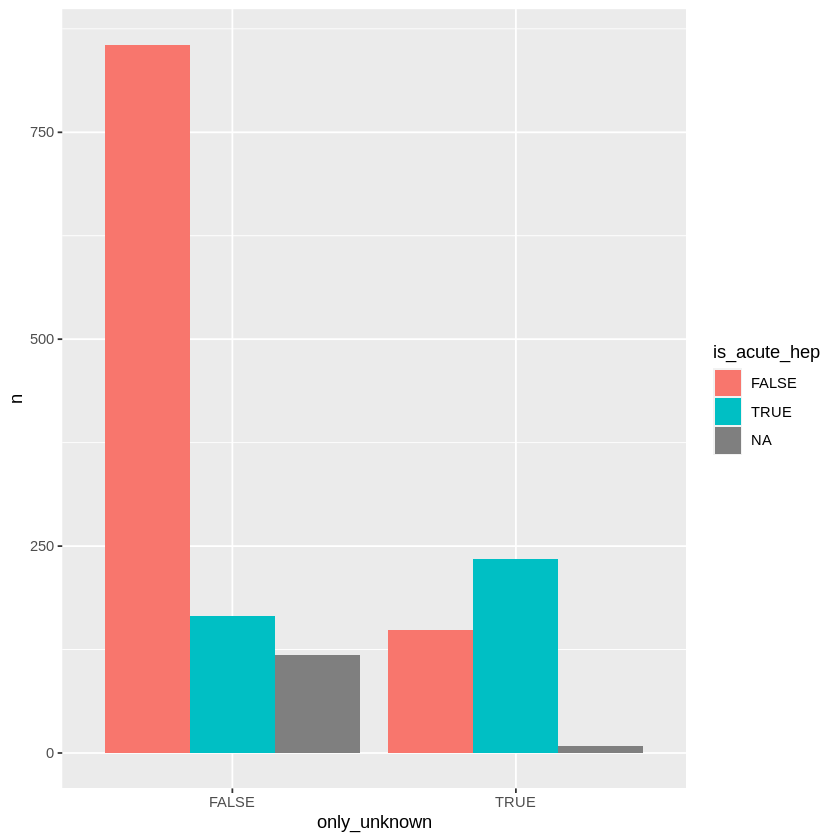

In [7]:
diag_filt %>%
    left_join(test_filt) %>%
#     filter(only_unknown) %>%
    group_by(only_unknown, is_acute_hep) %>%
    summarise(n = n()) %>%
    ggplot(aes(x = only_unknown, y = n, fill = is_acute_hep)) +
    geom_bar(stat = "identity", position = "dodge")

In [8]:
# diag_filt %>%
#     left_join(micro_df) %>%
#     select(ClusterID, AttendanceStartDate, only_unknown, BatTestCode, MicroTestName, ResultFull, BugName) %>%
#     filter(!is.na(MicroTestName)) %>%
#     filter(!grepl("not detected|no microorganisms detected|no viruses detected|DO NOT REPORT", ResultFull, ignore.case = T) &
#               grepl("detected", ResultFull, ignore.case = T)) %>%
#     distinct(MicroTestName, BatTestCode) %>%
#     arrange(BatTestCode)

In [9]:
adeno_tests

[1] "QADN" "RPCR" "EPCR" "OPCR" "QADN" "RGAS" "LRTP"

In [10]:
# diag_filt %>%
#     left_join(micro_df) %>%
#     select(ClusterID, AttendanceStartDate, only_unknown, BatTestCode, MicroTestName, ResultFull, BugName) %>%
#     filter(!is.na(MicroTestName)) %>%
#     filter(!(BatTestCode %in% c("EBNA"))) %>%
#     mutate(ResultFull = ifelse(BatTestCode %in% c('CV2G', 'CV2G2', 'CV2P', 'CV2Q', 'CV2V', 'RCV2Q', 'RCV2V') &
#                                    !grepl("not detected| |NONE|indeterminate", ResultFull, ignore.case = T),
#                                "detected", ResultFull)) %>%
#     filter(!grepl("not detected|no microorganisms detected|no viruses detected|DO NOT REPORT|NO BACTERIA OR VIRUSES DETECTED", ResultFull, ignore.case = T) &
#               grepl("detected", ResultFull, ignore.case = T)) %>%
#     mutate(parsed_results = case_when(grepl("CMV|HSV|EBV|HGPC|VZV", BatTestCode, ignore.case = T)|
#                                           (BatTestCode %in% c("VPCR", "OPCR") & 
#                                               grepl("Herpes Simplex Virus type 1 DETECTED", ResultFull, ignore.case = T))~ "Herpesvirus",
#                                       BatTestCode %in% c('CV2G', 'CV2G2', 'CV2P', 'CV2Q', 'CV2V', 'RCV2Q', 'RCV2V')|
#                                           grepl("Cov-2", MicroTestName, ignore.case = T) ~ "SARS-CoV-2",
#                                       grepl("HAV", BatTestCode) ~ "HAV",
#                                       grepl("HEV", BatTestCode) ~ "HEV",
#                                       grepl("HCV|HCAD", BatTestCode) ~ "HCV",
#                                       grepl("HBE|HBS|HBV|HBC", BatTestCode, ignore.case = T) ~ "HBV",
#                                       grepl("QADN", BatTestCode, ignore.case = T)|
#                                           (BatTestCode %in% adeno_tests$BatTestCode & 
#                                               grepl("adenovirus detected", ResultFull, ignore.case = T)) ~ "adenovirus"
#                                       )) %>%
#     mutate(parsed_results = ifelse(BugName == "adenovirus", "adenovirus", parsed_results)) %>%
#     filter(!is.na(parsed_results)) %>%
#     group_by(ClusterID, AttendanceStartDate, only_unknown) %>%
#     summarise(n_hepAtoE = sum(grepl("HAV|HBV|HCV|HEV", parsed_results)),
#               n_helper = sum(grepl("adenovirus|Herpesvirus", parsed_results)),
#               n_adeno = sum(grepl("adenovirus", parsed_results))) %>%
#     filter(n_helper > 0,
#            n_hepAtoE == 0,
#            only_unknown)

In [11]:
# Tested for adenovirus
merged_df <- adeno_filt %>%
    left_join(diag_filt) %>%
    left_join(test_filt) %>%
    left_join(death_filt) %>%
    left_join(spell_filt) %>%
    left_join(admit_filt) %>%
    mutate(aHep_or_unknDiag = is_acute_hep | only_unknown,
           age_group = factor(age_group, c("<7", "7-15", ">15")),
           is_outbreak = ifelse(AttendanceStartDate <= as.Date("2022-08-31") & AttendanceStartDate >= as.Date("2021-10-01"),
                                T, F),
           is_admitted = ifelse(is.na(AdmissionDate), F, T),
           only_unknown = ifelse(is.na(only_unknown), F, only_unknown),
           is_icu = ifelse(is.na(is_icu), F, is_icu),
           death = ifelse(is.na(death), F, death))

# Whole population
merged_df2 <- age_df %>%
    distinct(ClusterID, AttendanceStartDate, .keep_all = T) %>%
    left_join(adeno_filt) %>%
    left_join(spell_filt) %>%
    left_join(death_filt) %>%
    left_join(admit_filt) %>%
    left_join(diag_filt) %>%
    mutate(age_group = factor(age_group, c("<7", "7-15", ">15")),
           is_outbreak = ifelse(AttendanceStartDate <= as.Date("2022-08-31") & AttendanceStartDate >= as.Date("2021-10-01"),
                                T, F),
           only_unknown = ifelse(is.na(only_unknown), F, only_unknown),
           is_admitted = ifelse(is.na(AdmissionDate), F, T),
           is_icu = ifelse(is.na(is_icu), F, is_icu),
           death = ifelse(is.na(death), F, death)) %>%
    select(ClusterID, AttendanceStartDate, age_group, 
           is_outbreak, only_unknown, is_admitted, 
           is_icu, death, duration,
           adeno_pos)

# Diagnosed only
merged_df3 <- diag_filt %>%
    left_join(spell_filt) %>%
    left_join(death_filt) %>%
    left_join(admit_filt) %>%
    left_join(diag_filt) %>%
    mutate(age_group = factor(age_group, c("<7", "7-15", ">15")),
           is_outbreak = ifelse(AttendanceStartDate <= as.Date("2022-08-31") & AttendanceStartDate >= as.Date("2021-10-01"),
                                T, F),
           only_unknown = ifelse(is.na(only_unknown), F, only_unknown),
           is_admitted = ifelse(is.na(AdmissionDate), F, T),
           is_icu = ifelse(is.na(is_icu), F, is_icu),
           death = ifelse(is.na(death), F, death)) %>%
    select(ClusterID, AttendanceStartDate, age_group, is_outbreak, only_unknown, is_admitted, is_icu, death, duration)

Joining with `by = join_by(ClusterID, AttendanceStartDate)`
Joining with `by = join_by(ClusterID, AttendanceStartDate)`
Joining with `by = join_by(ClusterID, AttendanceStartDate)`
Joining with `by = join_by(ClusterID, AttendanceStartDate)`
Joining with `by = join_by(ClusterID, AttendanceStartDate)`
Joining with `by = join_by(ClusterID, AttendanceStartDate)`
Joining with `by = join_by(ClusterID, AttendanceStartDate)`
Joining with `by = join_by(ClusterID, AttendanceStartDate, age_group)`
Joining with `by = join_by(ClusterID, AttendanceStartDate)`
Joining with `by = join_by(ClusterID, AttendanceStartDate)`
Joining with `by = join_by(ClusterID, AttendanceStartDate)`
Joining with `by = join_by(ClusterID, AttendanceStartDate)`
Joining with `by = join_by(ClusterID, AttendanceStartDate)`
Joining with `by = join_by(ClusterID, AttendanceStartDate, only_unknown)`


### Summary statistics

In [12]:
# IMD score for entire population
age_df %>%
    distinct(ClusterID, AttendanceStartDate, .keep_all = T) %>%
    group_by(age_group) %>%
    mutate(IMDScore = as.numeric(IMDScore)) %>%
    filter(!is.na(IMDScore)) %>%
    summarise(median_IMD = median(IMDScore))

Warning message:
“There were 3 warnings in `mutate()`.
The first warning was:
ℹ In argument: `IMDScore = as.numeric(IMDScore)`.
ℹ In group 1: `age_group = "7-15"`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 2 remaining warnings.”


age_group,median_IMD
<chr>,<dbl>
7-15,11.101
<7,11.469
>15,11.511


In [13]:
# Admission stats for entire population
merged_df2 %>% nrow()
merged_df2 %>%
    group_by(age_group) %>%
    summarise(
#               n_death = sum(death),
              prop_death = round(sum(death) / n() * 100, 2),
#               n_icu = sum(is_icu),
              prop_icu = round(sum(is_icu) / n() * 100, 1),
#               n_admitted = sum(is_admitted),
              prop_admitted = round(sum(is_admitted) / n() * 100, 1),
              median_duration = round(median(duration, na.rm = T), 0),
              low_duration = round(quantile(duration, c(0.25), na.rm = T), 0),
              high_duration = round(quantile(duration, c(0.75), na.rm = T), 0),
              total = n())

[1] 903433

age_group,prop_death,prop_icu,prop_admitted,median_duration,low_duration,high_duration,total
<fct>,<dbl>,<dbl>,<dbl>,<drtn>,<drtn>,<drtn>,<int>
<7,0.01,0.4,17.0,20 hours,12 hours,42 hours,70962
7-15,0.01,0.3,13.2,24 hours,14 hours,49 hours,86217
>15,0.41,1.5,34.3,56 hours,22 hours,160 hours,746254


In [14]:
# Admission stats for patients tested for adenovirus
merged_df %>% nrow()
merged_df %>%
    summarise(
#               n_death = sum(death),
              prop_death = round(sum(death) / n() * 100, 2),
#               n_icu = sum(is_icu),
              prop_icu = round(sum(is_icu) / n() * 100, 1),
#               n_admitted = sum(is_admitted),
              prop_admitted = round(sum(is_admitted) / n() * 100, 1),
              median_duration = round(median(duration, na.rm = T), 0),
              low_duration = round(quantile(duration, c(0.25), na.rm = T), 0),
              high_duration = round(quantile(duration, c(0.75), na.rm = T), 0),
              total = n())

[1] 3707

prop_death,prop_icu,prop_admitted,median_duration,low_duration,high_duration,total
<dbl>,<dbl>,<dbl>,<drtn>,<drtn>,<drtn>,<int>
0.59,18.2,78.5,101 hours,45 hours,221 hours,3707


In [15]:
# Admission stats for patients untested for adenovirus
merged_df2 %>% 
    filter(is.na(adeno_pos)) %>%
           nrow()
merged_df2 %>%
    filter(is.na(adeno_pos)) %>%
    summarise(
#               n_death = sum(death),
              prop_death = round(sum(death) / n() * 100, 2),
#               n_icu = sum(is_icu),
              prop_icu = round(sum(is_icu) / n() * 100, 1),
#               n_admitted = sum(is_admitted),
              prop_admitted = round(sum(is_admitted) / n() * 100, 1),
              median_duration = round(median(duration, na.rm = T), 0),
              low_duration = round(quantile(duration, c(0.25), na.rm = T), 0),
              high_duration = round(quantile(duration, c(0.75), na.rm = T), 0),
              total = n())

[1] 899726

prop_death,prop_icu,prop_admitted,median_duration,low_duration,high_duration,total
<dbl>,<dbl>,<dbl>,<drtn>,<drtn>,<drtn>,<int>
0.34,1.2,30.7,50 hours,21 hours,145 hours,899726


In [16]:
# Admission stats for adeno-pos patients
merged_df %>% 
    filter(adeno_pos) %>%
    nrow()
merged_df %>%
    filter(adeno_pos) %>%
    summarise(
              n_death = sum(death),
              prop_death = round(sum(death) / n() * 100, 2),
              n_icu = sum(is_icu),
              prop_icu = round(sum(is_icu) / n() * 100, 1),
              n_admitted = sum(is_admitted),
              prop_admitted = round(sum(is_admitted) / n() * 100, 1),
              median_duration = round(median(duration, na.rm = T), 0),
              low_duration = round(quantile(duration, c(0.25), na.rm = T), 0),
              high_duration = round(quantile(duration, c(0.75), na.rm = T), 0),
              total = n())

[1] 179

n_death,prop_death,n_icu,prop_icu,n_admitted,prop_admitted,median_duration,low_duration,high_duration,total
<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<drtn>,<drtn>,<drtn>,<int>
0,0,21,11.7,109,60.9,65 hours,31 hours,139 hours,179


In [17]:
# Vital signs for adeno-pos patients
adeno_filt %>%
    left_join(death_filt) %>%
    filter(adeno_pos) %>%
    left_join(vital_df) %>%
    mutate(EventResult = as.numeric(EventResult),
           age_group = factor(age_group, c("<7", "7-15", ">15"))) %>%
    filter(!is.na(EventResult)) %>%
    group_by(EventName, age_group) %>%
    summarise(median_value = median(EventResult),
              low_IQR = quantile(EventResult, prob = c(0.25)),
              high_IQR = quantile(EventResult, prob = c(0.75)))
    

Joining with `by = join_by(ClusterID, AttendanceStartDate)`
Joining with `by = join_by(ClusterID, AttendanceStartDate)`
Warning message in left_join(., vital_df):
“Each row in `x` is expected to match at most 1 row in `y`.
ℹ Row 1 of `x` matches multiple rows.
ℹ If multiple matches are expected, set `multiple = "all"` to silence this warning.”
`summarise()` has grouped output by 'EventName'. You can override using the `.groups` argument.


EventName,age_group,median_value,low_IQR,high_IQR
<chr>,<fct>,<dbl>,<dbl>,<dbl>
Diastolic Blood Pressure,<7,61.0,54.000,71.500
Diastolic Blood Pressure,7-15,81.5,74.000,86.250
Diastolic Blood Pressure,>15,73.0,61.250,82.000
Heart Rate,<7,134.0,112.000,145.000
Heart Rate,7-15,111.0,109.000,123.000
Heart Rate,>15,92.0,84.000,105.500
Oxygen Saturation,<7,98.0,96.250,99.750
Oxygen Saturation,7-15,98.0,98.000,100.000
Oxygen Saturation,>15,96.0,95.000,98.000


In [18]:
# Admission stats for adeno-neg patients
merged_df %>% 
    filter(!adeno_pos) %>%
    nrow()
merged_df %>%
    filter(!adeno_pos) %>%
    summarise(
              n_death = sum(death),
              prop_death = round(sum(death) / n() * 100, 2),
              n_icu = sum(is_icu),
              prop_icu = round(sum(is_icu) / n() * 100, 1),
              n_admitted = sum(is_admitted),
              prop_admitted = round(sum(is_admitted) / n() * 100, 1),
              median_duration = round(median(duration, na.rm = T), 0),
              low_duration = round(quantile(duration, c(0.25), na.rm = T), 0),
              high_duration = round(quantile(duration, c(0.75), na.rm = T), 0),
              total = n())

[1] 3528

n_death,prop_death,n_icu,prop_icu,n_admitted,prop_admitted,median_duration,low_duration,high_duration,total
<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<drtn>,<drtn>,<drtn>,<int>
22,0.62,654,18.5,2802,79.4,102 hours,46 hours,224 hours,3528


In [19]:
# Admission stats for all diagnosed patients
merged_df3 %>% 
    nrow()
merged_df3 %>%
    summarise(
              n_death = sum(death),
              prop_death = round(sum(death) / n() * 100, 2),
              n_icu = sum(is_icu),
              prop_icu = round(sum(is_icu) / n() * 100, 1),
              n_admitted = sum(is_admitted),
              prop_admitted = round(sum(is_admitted) / n() * 100, 1),
              median_duration = round(median(duration, na.rm = T), 0),
              low_duration = round(quantile(duration, c(0.25), na.rm = T), 0),
              high_duration = round(quantile(duration, c(0.75), na.rm = T), 0),
              total = n())

[1] 1531

n_death,prop_death,n_icu,prop_icu,n_admitted,prop_admitted,median_duration,low_duration,high_duration,total
<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<drtn>,<drtn>,<drtn>,<int>
17,1.11,188,12.3,1531,100,93 hours,35 hours,234 hours,1531


In [20]:
# Admission stats for AHUA patients
merged_df2 %>% 
    filter(only_unknown) %>%
    nrow()
merged_df2 %>%
    filter(only_unknown) %>%
    summarise(
              n_death = sum(death),
              prop_death = round(sum(death) / n() * 100, 2),
              n_icu = sum(is_icu),
              prop_icu = round(sum(is_icu) / n() * 100, 1),
              n_admitted = sum(is_admitted),
              prop_admitted = round(sum(is_admitted) / n() * 100, 1),
              median_duration = round(median(duration, na.rm = T), 0),
              low_duration = round(quantile(duration, c(0.25), na.rm = T), 0),
              high_duration = round(quantile(duration, c(0.75), na.rm = T), 0),
              total = n())

[1] 391

n_death,prop_death,n_icu,prop_icu,n_admitted,prop_admitted,median_duration,low_duration,high_duration,total
<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<drtn>,<drtn>,<drtn>,<int>
13,3.32,102,26.1,391,100,146 hours,57 hours,333 hours,391


In [21]:
# Admission stats for non-AHUA patients
merged_df2 %>% 
    filter(!only_unknown) %>%
    nrow()
merged_df2 %>%
    filter(!only_unknown) %>%
    summarise(
#               n_death = sum(death),
              prop_death = round(sum(death) / n() * 100, 2),
#               n_icu = sum(is_icu),
              prop_icu = round(sum(is_icu) / n() * 100, 1),
#               n_admitted = sum(is_admitted),
              prop_admitted = round(sum(is_admitted) / n() * 100, 1),
              median_duration = round(median(duration, na.rm = T), 0),
              low_duration = round(quantile(duration, c(0.25), na.rm = T), 0),
              high_duration = round(quantile(duration, c(0.75), na.rm = T), 0),
              total = n())

[1] 903042

prop_death,prop_icu,prop_admitted,median_duration,low_duration,high_duration,total
<dbl>,<dbl>,<dbl>,<drtn>,<drtn>,<drtn>,<int>
0.34,1.3,30.9,50 hours,21 hours,145 hours,903042


In [22]:
# Admission stats for viral hep A-E patients
merged_df3 %>% 
    filter(!only_unknown) %>%
    nrow()
merged_df3 %>%
    filter(!only_unknown) %>%
    summarise(
#               n_death = sum(death),
              prop_death = round(sum(death) / n() * 100, 2),
#               n_icu = sum(is_icu),
              prop_icu = round(sum(is_icu) / n() * 100, 1),
#               n_admitted = sum(is_admitted),
              prop_admitted = round(sum(is_admitted) / n() * 100, 1),
              median_duration = round(median(duration, na.rm = T), 0),
              low_duration = round(quantile(duration, c(0.25), na.rm = T), 0),
              high_duration = round(quantile(duration, c(0.75), na.rm = T), 0),
              total = n())

[1] 1140

prop_death,prop_icu,prop_admitted,median_duration,low_duration,high_duration,total
<dbl>,<dbl>,<dbl>,<drtn>,<drtn>,<drtn>,<int>
0.35,7.5,100,79 hours,29 hours,199 hours,1140


In [23]:
# Adenovirus infections
merged_df %>%
    filter(adeno_pos) %>%
    group_by(age_group) %>%
    summarise(n_death = sum(death),
              prop_death = sum(death) / n(),
              n_icu = sum(is_icu),
              prop_icu = sum(is_icu / n()),
              n_admitted = sum(is_admitted),
              prop_admitted = sum(is_admitted / n()),
              median_duration = median(duration, na.rm = T),
              low_duration = quantile(duration, c(0.25), na.rm = T),
              high_duration = quantile(duration, c(0.75), na.rm = T),
              total = n())

age_group,n_death,prop_death,n_icu,prop_icu,n_admitted,prop_admitted,median_duration,low_duration,high_duration,total
<fct>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<drtn>,<drtn>,<drtn>,<int>
<7,0,0,9,0.07258065,74,0.5967742,56.30347 hours,25.58139 hours,95.42354 hours,124
7-15,0,0,0,0.00000000,5,0.5555556,117.76667 hours,33.03417 hours,308.59972 hours,9
>15,0,0,12,0.26086957,30,0.6521739,125.05833 hours,48.81667 hours,450.31451 hours,46


### AHUA versus population

In [24]:
# ICU
merged_df2_within <- merged_df2 %>% filter(is_outbreak)
merged_df2_outside <- merged_df2 %>% filter(!is_outbreak)

cont <- table(merged_df2_within$only_unknown, merged_df2_within$is_icu)
fisher.test(cont)

cont <- table(merged_df2_outside$only_unknown, merged_df2_outside$is_icu)
fisher.test(cont)

## Admission
# cont <- table(merged_df2_within$only_unknown, merged_df2_within$is_admitted)
# fisher.test(cont)

# cont <- table(merged_df2_outside$only_unknown, merged_df2_outside$is_admitted)
# fisher.test(cont)

# Death
cont <- table(merged_df2_within$only_unknown, merged_df2_within$death)
fisher.test(cont)

cont <- table(merged_df2_outside$only_unknown, merged_df2_outside$death)
fisher.test(cont)


	Fisher's Exact Test for Count Data

data:  cont
p-value < 2.2e-16
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 26.33765 65.03387
sample estimates:
odds ratio 
  41.73853 



	Fisher's Exact Test for Count Data

data:  cont
p-value < 2.2e-16
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 17.83642 31.17072
sample estimates:
odds ratio 
  23.71221 



	Fisher's Exact Test for Count Data

data:  cont
p-value = 0.03502
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  0.8312358 26.1138750
sample estimates:
odds ratio 
   6.98903 



	Fisher's Exact Test for Count Data

data:  cont
p-value = 9.789e-09
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  5.553269 20.494328
sample estimates:
odds ratio 
  11.26462 


Don't know how to automatically pick scale for object of type <difftime>. Defaulting to continuous.
Don't know how to automatically pick scale for object of type <difftime>. Defaulting to continuous.


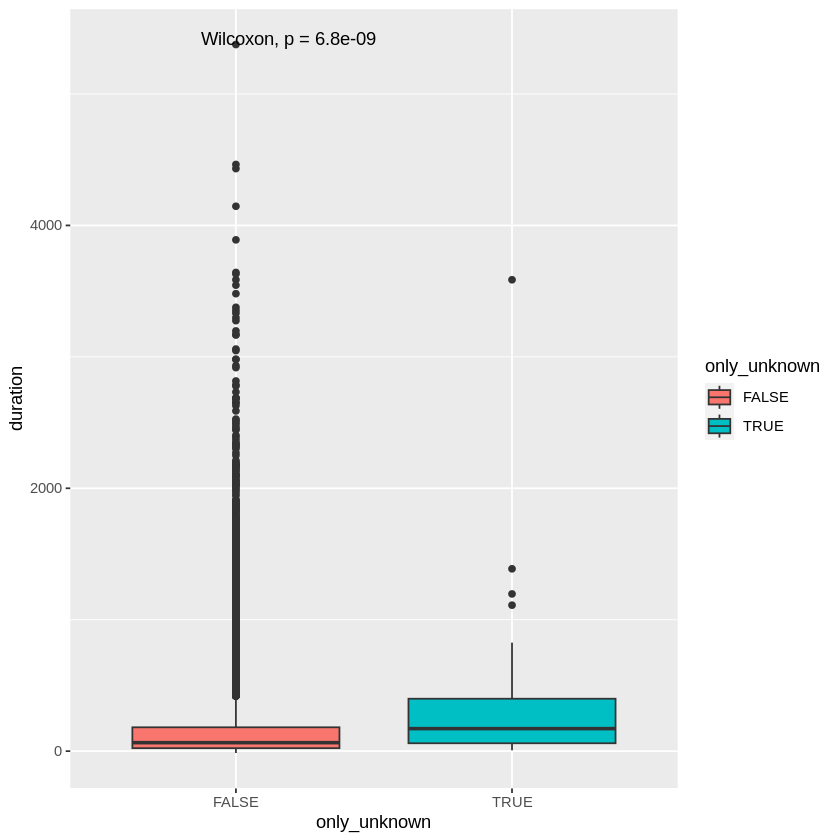

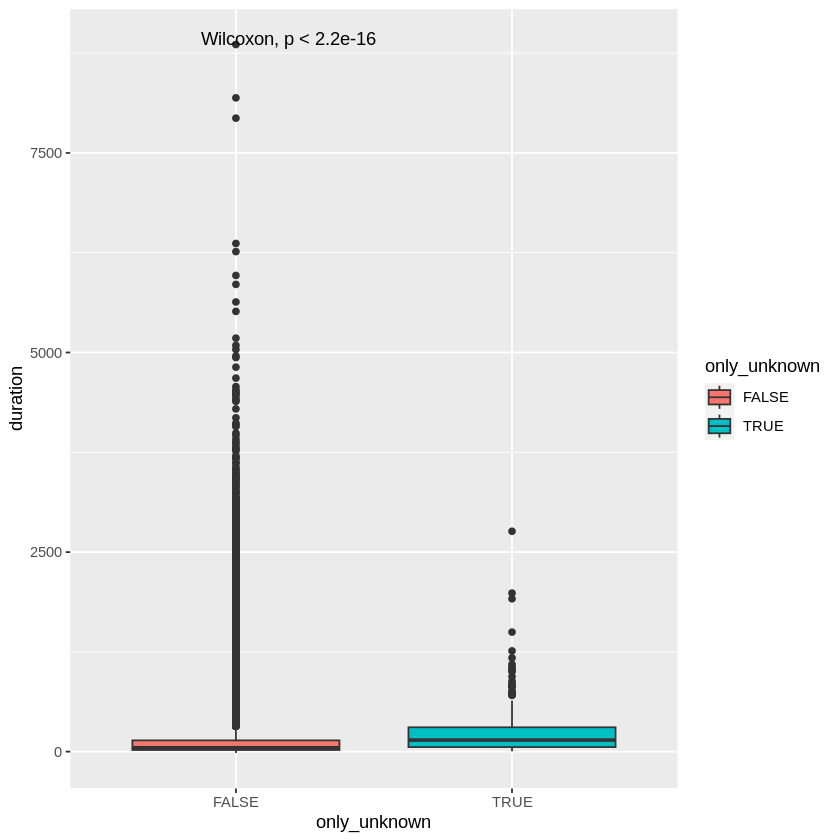

In [25]:
merged_filt2_within <- merged_df2 %>%
    filter(!is.na(duration)) %>%
    filter(is_outbreak)

merged_filt2_outside <- merged_df2 %>%
    filter(!is.na(duration)) %>%
    filter(!is_outbreak)


merged_filt2_within %>%
    ggplot(aes(x = only_unknown, y = duration, fill = only_unknown)) +
    geom_boxplot() +
    stat_compare_means()

merged_filt2_outside %>%
    ggplot(aes(x = only_unknown, y = duration, fill = only_unknown)) +
    geom_boxplot() +
    stat_compare_means()

## AHUA versus viral hep A-E

In [26]:
# ICU
merged_df3_within <- merged_df3 %>% filter(is_outbreak)
merged_df3_outside <- merged_df3 %>% filter(!is_outbreak)

cont <- table(merged_df3_within$only_unknown, merged_df3_within$is_icu)
fisher.test(cont)

cont <- table(merged_df3_outside$only_unknown, merged_df3_outside$is_icu)
fisher.test(cont)

## Admission
# cont <- table(merged_df2_within$only_unknown, merged_df2_within$is_admitted)
# fisher.test(cont)

# cont <- table(merged_df2_outside$only_unknown, merged_df2_outside$is_admitted)
# fisher.test(cont)

# Death
cont <- table(merged_df3_within$only_unknown, merged_df3_within$death)
fisher.test(cont)

cont <- table(merged_df3_outside$only_unknown, merged_df3_outside$death)
fisher.test(cont)


	Fisher's Exact Test for Count Data

data:  cont
p-value = 2.076e-05
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  2.218353 12.242694
sample estimates:
odds ratio 
  5.009855 



	Fisher's Exact Test for Count Data

data:  cont
p-value = 4.069e-13
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 2.685407 5.649673
sample estimates:
odds ratio 
  3.896024 



	Fisher's Exact Test for Count Data

data:  cont
p-value = 1
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  0.08253852 16.26788691
sample estimates:
odds ratio 
  1.158741 



	Fisher's Exact Test for Count Data

data:  cont
p-value = 2.909e-06
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
   4.292504 184.819621
sample estimates:
odds ratio 
  19.82578 


### Adenovirus infections

`summarise()` has grouped output by 'adeno_pos'. You can override using the `.groups` argument.


adeno_pos,is_outbreak,prop_icu,prop_death,prop_admit,median_duration
<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<drtn>
FALSE,FALSE,0.20589305,0.006184067,0.7930156,101.38861 hours
FALSE,TRUE,0.11296534,0.006418485,0.7984596,105.56944 hours
TRUE,FALSE,0.16806723,0.000000000,0.6302521,72.00000 hours
TRUE,TRUE,0.01666667,0.000000000,0.5666667,57.68278 hours


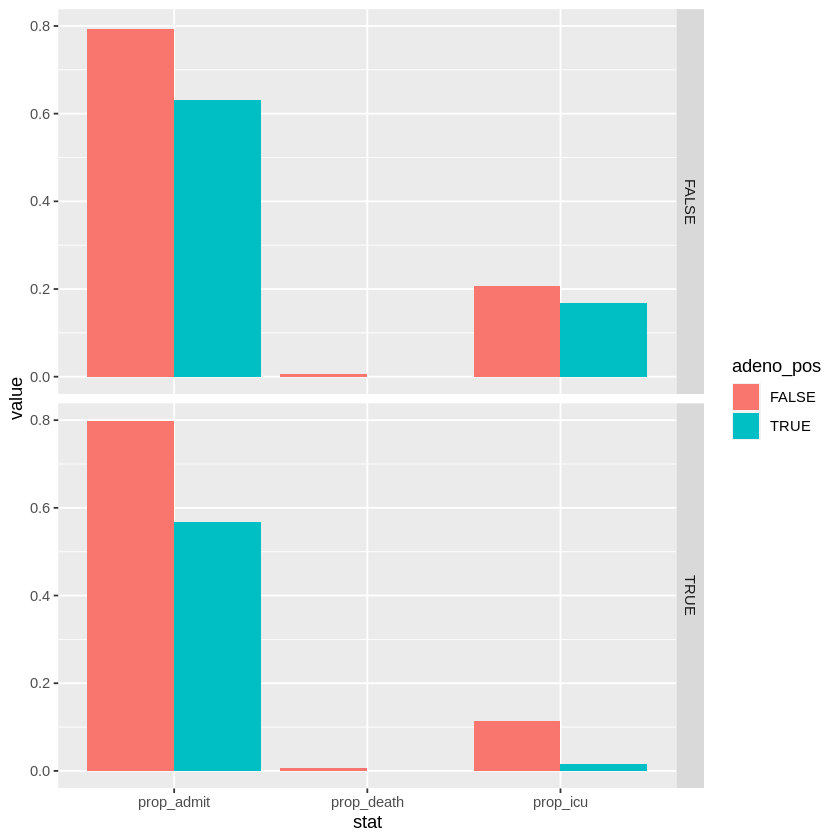

In [28]:
merged_stats <- merged_df %>%
    group_by(adeno_pos, is_outbreak) %>%
    summarise(prop_icu = sum(is_icu, na.rm = T) / n_distinct(ClusterID, AttendanceStartDate),
              prop_death = sum(death, na.rm = T) / n_distinct(ClusterID, AttendanceStartDate),
              prop_admit = sum(is_admitted) / n_distinct(ClusterID, AttendanceStartDate),
              median_duration = median(duration, na.rm = T))
merged_stats

merged_stats %>%
    select(-median_duration) %>%
    pivot_longer(!c("adeno_pos", "is_outbreak"), names_to = "stat", values_to = "value") %>%
    ggplot(aes(x = stat, y = value, fill = adeno_pos)) +
    geom_bar(stat = "identity", position = "dodge") +
    facet_grid(rows = vars(is_outbreak))

In [29]:
# Fisher exact test for admissions
print("ADMISSIONS")
test <- merged_df %>%
    filter(!is.na(is_admitted)) %>%
    filter(!is_outbreak) %>%
    select(is_admitted, adeno_pos)
table(test)
fisher.test(table(test))

test <- merged_df %>%
    filter(!is.na(is_admitted)) %>%
    filter(is_outbreak) %>%
    select(is_admitted, adeno_pos)
table(test)
fisher.test(table(test))

# ICU
print("ICU")
test <- merged_df %>%
    filter(!is.na(is_icu)) %>%
    filter(!is_outbreak) %>%
    select(is_icu, adeno_pos)
table(test)
fisher.test(table(test))

test <- merged_df %>%
    filter(!is.na(is_icu)) %>%
    filter(is_outbreak) %>%
    select(is_icu, adeno_pos)
table(test)
fisher.test(table(test))

# Death
print("Death")
test <- merged_df %>%
    filter(!is.na(death)) %>%
    filter(!is_outbreak) %>%
    select(death, adeno_pos)
table(test)
fisher.test(table(test))$p.value
            
test <- merged_df %>%
    filter(!is.na(death)) %>%
    filter(is_outbreak) %>%
    select(death, adeno_pos)
table(test)
fisher.test(table(test))$p.value

[1] "ADMISSIONS"


           adeno_pos
is_admitted FALSE TRUE
      FALSE   569   44
      TRUE   2180   75


	Fisher's Exact Test for Count Data

data:  table(test)
p-value = 8.067e-05
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.2989955 0.6691295
sample estimates:
odds ratio 
 0.4450509 


           adeno_pos
is_admitted FALSE TRUE
      FALSE   157   26
      TRUE    622   34


	Fisher's Exact Test for Count Data

data:  table(test)
p-value = 0.0001231
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.1863954 0.5919480
sample estimates:
odds ratio 
 0.3306348 


[1] "ICU"


       adeno_pos
is_icu  FALSE TRUE
  FALSE  2183   99
  TRUE    566   20


	Fisher's Exact Test for Count Data

data:  table(test)
p-value = 0.3542
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.4522408 1.2825318
sample estimates:
odds ratio 
 0.7792373 


       adeno_pos
is_icu  FALSE TRUE
  FALSE   691   59
  TRUE     88    1


	Fisher's Exact Test for Count Data

data:  table(test)
p-value = 0.01496
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.003281108 0.793416781
sample estimates:
odds ratio 
 0.1332514 


[1] "Death"


       adeno_pos
death   FALSE TRUE
  FALSE  2732  119
  TRUE     17    0

[1] 1

       adeno_pos
death   FALSE TRUE
  FALSE   774   60
  TRUE      5    0

[1] 1

Don't know how to automatically pick scale for object of type <difftime>. Defaulting to continuous.


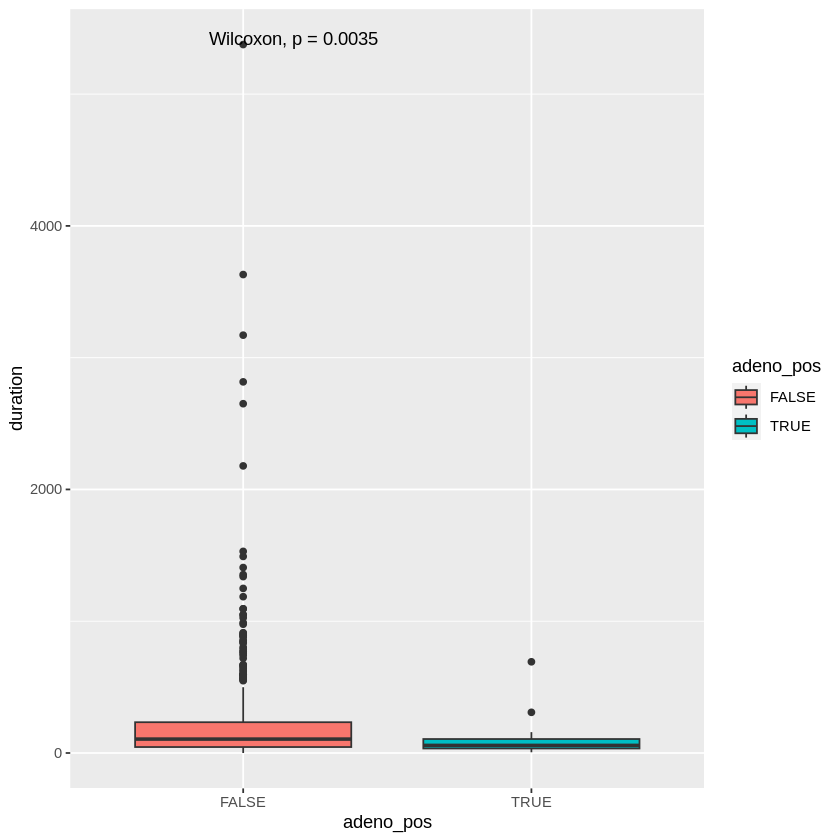

In [30]:
merged_df %>%
    filter(!is.na(duration)) %>%
    filter(is_outbreak) %>%
    ggplot(aes(x = adeno_pos, y = duration, fill = adeno_pos)) +
#     geom_density(alpha = 0.5) +
    geom_boxplot() +
    stat_compare_means()

### Diagnostic codes

In [ ]:
diag_merged <- diag_filt %>%
    left_join(test_filt) %>%
    left_join(death_filt) %>%
    left_join(spell_filt) %>%
    left_join(admit_filt) %>%
    mutate(aHep_or_unknDiag = is_acute_hep | only_unknown,
           age_group = factor(age_group, c("<7", "7-15", ">15")),
           is_outbreak = ifelse(AttendanceStartDate <= as.Date("2022-08-31") & AttendanceStartDate >= as.Date("2021-10-01"),
                                T, F),
           is_admitted = ifelse(is.na(AdmissionDate), F, T))

diag_merged %>%
    filter(only_unknown) %>%
    group_by(age_group) %>%
    summarise(n_outbreak = sum(is_outbreak),
              n_total =  n(), 
              perc = sum(is_outbreak) / n())


In [ ]:
diag_stats <- diag_merged %>%
    filter(!is.na(only_unknown)) %>%
    group_by(is_outbreak, only_unknown) %>%
    summarise(prop_icu = sum(is_icu, na.rm = T) / n_distinct(ClusterID, AttendanceStartDate),
              prop_death = sum(death, na.rm = T) / n_distinct(ClusterID, AttendanceStartDate),
              median_duration = median(duration, na.rm = T)) 

diag_stats %>%
    select(-median_duration) %>%
    pivot_longer(!c("only_unknown", "is_outbreak"), names_to = "stat", values_to = "value") %>%
    ggplot(aes(x = stat, y = value, fill = is_outbreak)) +
    geom_bar(stat = "identity", position = "dodge") +
    facet_grid(rows = vars(only_unknown)) +
    scale_y_continuous(sec.axis = sec_axis(trans = ~., name="Liver-related disease unknown cause"))


In [ ]:
diag_merged


In [ ]:
# ICU
print("ICU")
test <- diag_merged %>%
    filter(!is.na(is_icu)) %>%
    filter(is_outbreak) %>%
    select(is_icu, only_unknown)
table(test)
fisher.test(table(test))

test <- diag_merged %>%
    filter(!is.na(is_icu)) %>%
    filter(!is_outbreak) %>%
    select(is_icu, only_unknown)
table(test)
fisher.test(table(test))

# Death
print("Death")
test <- diag_merged %>%
    filter(!is.na(death)) %>%
    filter(is_outbreak) %>%
    select(death, only_unknown)
table(test)
fisher.test(table(test))
            
test <- diag_merged %>%
    filter(!is.na(death)) %>%
    filter(!is_outbreak) %>%
    select(death, only_unknown)
table(test)
fisher.test(table(test))

In [ ]:
# ICU
print("ICU")
test <- merged_df %>%
    filter(!is.na(only_unknown)) %>%
    filter(!is_outbreak) %>%
    select(is_icu, only_unknown)
table(test)
fisher.test(table(test))

test <- merged_df %>%
    filter(!is.na(only_unknown)) %>%
    filter(is_outbreak) %>%
    select(is_icu, only_unknown)
table(test)
fisher.test(table(test))


# Death
print("DEATH")
test <- merged_df %>%
    filter(!is.na(death)) %>%
    filter(!is_outbreak) %>%
    select(death, only_unknown)
table(test)
fisher.test(table(test))

test <- merged_df %>%
    filter(!is.na(death)) %>%
    filter(is_outbreak) %>%
    select(death, only_unknown)
table(test)
fisher.test(table(test))

In [ ]:
diag_merged %>%
    filter(!is.na(duration)) %>%
    filter(is_outbreak) %>%
    ggplot(aes(x = only_unknown, y = duration, fill = only_unknown)) +
#     geom_density(alpha = 0.5) +
    geom_boxplot() +
    stat_compare_means()

diag_merged %>%
    filter(!is.na(duration)) %>%
    filter(!is_outbreak) %>%
    ggplot(aes(x = only_unknown, y = duration, fill = only_unknown)) +
#     geom_density(alpha = 0.5) +
    geom_boxplot() +
    stat_compare_means()

In [ ]:
# Vital signs
adeno_filt %>%
    left_join(death_filt) %>%
    filter(adeno_pos) %>%
    left_join(vital_df) %>%
    mutate(EventResult = as.numeric(EventResult),
           age_group = factor(age_group, c("<7", "7-15", ">15"))) %>%
    filter(!is.na(EventResult)) %>%
    group_by(EventName, age_group) %>%
    summarise(median_value = median(EventResult),
              low_IQR = quantile(EventResult, prob = c(0.25)),
              high_IQR = quantile(EventResult, prob = c(0.75)))
    

# SCRATCH

In [ ]:
# death_filt %>% 
#     right_join(test_df) %>%
#     left_join(micro_df %>% select(ClusterID, AttendanceStartDate, BatTestCode, ResultFull, BugName)) %>% 
#     filter(TestName %in% c("ALT", "AST")) %>%
#     mutate(Value = as.numeric(Value)) %>%
#     filter(!is.na(Value)) %>%
#     filter(Value > 500) %>%
#     filter(AttendanceStartDate >= as.Date("2021-10-01")) %>%
#     filter(age_group != ">15") %>%
#     arrange(AttendanceStartDate) %>%
#     filter(BugName == "NULL") %>%
#     distinct(ResultFull)

In [ ]:
# death_filt %>% 
#     right_join(test_df) %>%
#     left_join(micro_df %>% select(ClusterID, AttendanceStartDate, BatTestCode, ResultFull, BugName)) %>% 
#     filter(TestName %in% c("ALT", "AST")) %>%
#     mutate(Value = as.numeric(Value)) %>%
#     filter(!is.na(Value)) %>%
#     filter(Value > 500) %>%
#     filter(AttendanceStartDate >= as.Date("2021-10-01")) %>%
#     filter(age_group != ">15") %>%
#     arrange(AttendanceStartDate) %>%
#     filter(!grepl("Not detected|no significant|no growth|No microorganisms|none|NA|no serological|do not report|NO METHICILLIN RESISTANT|not seen", ResultFull, ignore.case = T)) %>%
#     distinct(ResultFull)

In [ ]:
# death_filt %>% 
#     right_join(test_df) %>%
#     left_join(micro_df %>% select(ClusterID, AttendanceStartDate, BatTestCode, ResultFull, BugName)) %>% 
#     filter(TestName %in% c("ALT", "AST")) %>%
#     mutate(Value = as.numeric(Value)) %>%
#     filter(!is.na(Value)) %>%
#     filter(Value > 500) %>%
# #     filter(AttendanceStartDate >= as.Date("2021-10-01")) %>%
#     filter(age_group != ">15") %>%
#     mutate(has_bug = ifelse(grepl("NOT TESTED|test declined|unsuitable sample|Sample does not meet the criteria|Not detected|no significant|no growth|No microorganisms|none|NA|no serological|do not report|NO METHICILLIN RESISTANT|not seen", 
#                                   ResultFull, 
#                                   ignore.case = T),
#                             F, T))
# #     distinct(ClusterID, AttendanceStartDate)
#     group_by(AttendanceStartDate, ClusterID) %>%
#     summarise(n_bugs = sum(has_bug)) %>%
#     filter()

In [ ]:
covid_filt <- micro_df %>%
  filter(BatTestCode %in% c('CV2G', 'CV2G2', 'CV2P', 'CV2Q', 'CV2V', 'RCV2Q', 'RCV2V')) %>%
  mutate(is_covid = ifelse(grepl("not detected| |NONE|indeterminate", ResultFull, ignore.case = T), F, T)) %>%
    group_by(ClusterID, AttendanceStartDate) %>%
    summarise(n_pos = sum(is_covid)) %>%
    mutate(is_covid = n_pos > 0) %>%
    select(-n_pos) %>%
    mutate(AttendanceMonth = cut(AttendanceStartDate, breaks = "month"),
           AttendanceTwoMonth = cut(AttendanceStartDate, breaks = "2 months")) %>%
    mutate(AttendanceMonth = as.Date(AttendanceMonth))

covid_filt

### AHUA cases after accounting for COVID

In [ ]:
# test_filt %>% 
#     left_join(viral_hep_filt) %>%
#     left_join(diag_filt) %>%
#     filter(!is.na(only_unknown))

In [ ]:
test_filt %>% 
    left_join(viral_hep_filt) %>%
    left_join(diag_filt) %>%
    filter(!is.na(only_unknown)) %>%
    mutate(is_viral_hep = ifelse(is.na(is_viral_hep), F, is_viral_hep)) %>%
#     filter(is_acute_hep) %>%
    distinct(ClusterID, AttendanceStartDate, .keep_all = T) %>%
    mutate(AttendanceMonth = cut(AttendanceStartDate, breaks = "month"),
           AttendanceTwoMonth = cut(AttendanceStartDate, breaks = "2 months")) %>%
    mutate(AttendanceMonth = as.Date(AttendanceMonth)) %>%
    group_by(AttendanceMonth) %>%
    summarise(n = sum(!is_viral_hep & is_acute_hep) / n()) %>%
    ggplot(aes(x = AttendanceMonth, y = n)) +
    geom_point() + geom_line()

In [ ]:
viral_hep <- test_filt %>% 
    left_join(viral_hep_filt) %>%
    left_join(diag_filt) %>%
    filter(is.na(only_unknown)) %>%
    mutate(is_viral_hep = ifelse(is.na(is_viral_hep), F, is_viral_hep)) %>%
    filter(is_acute_hep, is_viral_hep) %>%
    distinct(ClusterID, AttendanceStartDate, .keep_all = T) %>%
    mutate(AttendanceMonth = cut(AttendanceStartDate, breaks = "month"),
           AttendanceTwoMonth = cut(AttendanceStartDate, breaks = "2 months")) %>%
    mutate(AttendanceMonth = as.Date(AttendanceMonth)) %>%
    group_by(AttendanceMonth) %>%
    summarise(n_viral = n())

unknown_hep <- test_filt %>% 
    left_join(viral_hep_filt) %>%
    left_join(diag_filt) %>%
    filter(is.na(only_unknown)) %>%
    mutate(is_viral_hep = ifelse(is.na(is_viral_hep), F, is_viral_hep)) %>%
    filter(is_acute_hep, !is_viral_hep) %>%
    distinct(ClusterID, AttendanceStartDate, .keep_all = T) %>%
    mutate(AttendanceMonth = cut(AttendanceStartDate, breaks = "month"),
           AttendanceTwoMonth = cut(AttendanceStartDate, breaks = "2 months")) %>%
    mutate(AttendanceMonth = as.Date(AttendanceMonth)) %>%
    group_by(AttendanceMonth) %>%
    summarise(n_unknown = n())

unknown_hep %>%
    left_join(viral_hep) %>%
    mutate(n_viral = ifelse(n_viral =))
    mutate(ratio = n_unknown / n_viral)

In [ ]:
covid_plt <- covid_filt %>%
    group_by(AttendanceMonth) %>%
    summarise(prop = sum(is_covid) / n()) %>%
     ggplot(aes(x = AttendanceMonth, y = prop)) +
        geom_point() +
        geom_line() +
            annotate("rect",
             xmin = as.Date(-Inf), xmax = as.Date("2020-03-01"), 
             ymin = -Inf, ymax = Inf,
             fill = "grey83",
             alpha = 0.3) +
            annotate("rect",
                     xmin = as.Date("2020-03-01"), xmax = as.Date(Inf), 
                     ymin = -Inf, ymax = Inf,
                     fill = "lightgoldenrod1",
                     alpha = 0.3) +
            annotate("rect",
                 xmin = as.Date("2021-10-01"), xmax = as.Date("2022-08-01"), 
                 ymin = -Inf, ymax = Inf,
                 fill = NA,
                 color = "black",
                 lty = "dashed",
                 alpha = 0.3) +
        scale_x_date(date_labels="%b-%y", date_breaks  = "2 month", limits = c(as.Date("2016-02-01"), 
                                                                               as.Date("2023-01-01"))) +
            theme_bw() +
        theme(axis.text.x = element_text(angle = 90, vjust = 0.5))

hep_plt <- test_filt %>% 
    left_join(viral_hep_filt) %>%
    left_join(diag_filt) %>%
    left_join(covid_filt) %>%
    filter(is.na(only_unknown)) %>%
    mutate(is_viral_hep = ifelse(is.na(is_viral_hep), F, is_viral_hep),
           is_covid = ifelse(is.na(is_covid), F, is_covid)) %>%
    filter(is_acute_hep) %>%
    distinct(ClusterID, AttendanceStartDate, .keep_all = T) %>%
    mutate(AttendanceMonth = cut(AttendanceStartDate, breaks = "month"),
           AttendanceTwoMonth = cut(AttendanceStartDate, breaks = "2 months")) %>%
    mutate(AttendanceMonth = as.Date(AttendanceMonth)) %>%
    group_by(AttendanceMonth, is_viral_hep) %>%
    summarise(n = n()) %>%
    ggplot(aes(x = AttendanceMonth, y = n)) +
    geom_point() +
    geom_line() +
    facet_grid(rows = vars(is_viral_hep), scales = "free") +
        annotate("rect",
         xmin = as.Date(-Inf), xmax = as.Date("2020-03-01"), 
         ymin = -Inf, ymax = Inf,
         fill = "grey83",
         alpha = 0.3) +
        annotate("rect",
                 xmin = as.Date("2020-03-01"), xmax = as.Date(Inf), 
                 ymin = -Inf, ymax = Inf,
                 fill = "lightgoldenrod1",
                 alpha = 0.3) +
        annotate("rect",
             xmin = as.Date("2021-10-01"), xmax = as.Date("2022-08-01"), 
             ymin = -Inf, ymax = Inf,
             fill = NA,
             color = "black",
             lty = "dashed",
             alpha = 0.3) +
        scale_x_date(date_labels="%b-%y", date_breaks  = "2 month", limits = c(as.Date("2016-02-01"), 
                                                                               as.Date("2023-01-01"))) +
        theme_bw()

ggarrange(covid_plt, hep_plt, nrow = 2)

In [ ]:
adeno_filt %>%
    left_join(death_filt) %>%
    group_by(age_group) %>%
    summarise(n = n())

diag_filt %>%
    left_join(death_filt) %>%
    group_by(age_group) %>%
    summarise(n = n())